Trains a Neural Network using the Data-Generator.

In [1]:
from keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from datagenerator import DataGenerator
import datetime
import pickle
from pyntcloud import PyntCloud
from mpl_toolkits.mplot3d import Axes3D

/Users/tristanbehrens/Development/python-venvs/venv-3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Datasetpath.

In [2]:
if os.path.exists("datasetpath.txt"):
    dataset_path = open("datasetpath.txt", "r").read().replace("\n", "")
else:
    dataset_path = "../data"

# Instantiate the data-generator.

In [3]:
data_generator = DataGenerator(dataset_path=dataset_path, input_type="empty", output_targets=["height", "weight"])

print("jpg_paths", len(data_generator.jpg_paths))
print("pcd_paths", len(data_generator.pcd_paths))
print("json_paths_personal", len(data_generator.json_paths_personal))
print("json_paths_measures", len(data_generator.json_paths_measures))
print("QR-Codes:\n" + "\n".join(data_generator.qrcodes))

print("Done.")

jpg_paths 4511
pcd_paths 1360
json_paths_personal 40
json_paths_measures 74
QR-Codes:
SAM-02-003-01
SAM-GOV-001
SAM-GOV-002
SAM-GOV-003
SAM-GOV-004
SAM-GOV-005
SAM-GOV-008
SAM-GOV-011
SAM-GOV-012
SAM-GOV-013
SAM-GOV-014
SAM-GOV-023
SAM-GOV-025
SAM-GOV-026
SAM-GOV-033
SAM-GOV-034
SAM-GOV-035
SAM-GOV-036
SAM-GOV-037
SAM-GOV-038
SAM-GOV-041
SAM-GOV-042
SAM-GOV-043
SAM-GOV-044
SAM-GOV-099
SAM-SNG-011
SAM-SNG-012
SAM-SNG-013
SAM-SNG-014
SAM-SNG-015
SAM-SNG-016
SAM-SNG-021
SAM-SNG-036
SAM-SNG-066
SAM-SNG-067
SAM-SNG-072
SAM-SNG-091
SAM-SNG-096
Done.


#  Do the training-validation-split on QR-codes.

In [7]:
# Ensure that the split is always the same.
random.seed(108)

# Filter and shuffle the QR-Codes.
qrcodes_shuffle = list(data_generator.qrcodes)
qrcodes_shuffle = [qrcode for qrcode in qrcodes_shuffle if qrcode.startswith("SAM-GOV")]
random.shuffle(qrcodes_shuffle)

# Do the split.
split_index = int(0.8 * len(qrcodes_shuffle))
qrcodes_train = qrcodes_shuffle[:split_index]
qrcodes_validate = qrcodes_shuffle[split_index:]

# Print statistics.
print("QR-Codes train:")
print(" ".join(qrcodes_train))
print("")
print("QR-Codes validate:")
print(" ".join(qrcodes_validate))
print("")
print("Done.")

QR-Codes train:
SAM-GOV-023 SAM-GOV-041 SAM-GOV-033 SAM-GOV-037 SAM-GOV-012 SAM-GOV-099 SAM-GOV-001 SAM-GOV-035 SAM-GOV-002 SAM-GOV-038 SAM-GOV-008 SAM-GOV-025 SAM-GOV-034 SAM-GOV-036 SAM-GOV-004 SAM-GOV-014 SAM-GOV-043 SAM-GOV-011 SAM-GOV-042

QR-Codes validate:
SAM-GOV-013 SAM-GOV-026 SAM-GOV-003 SAM-GOV-044 SAM-GOV-005

Done.


# Training.


In [ ]:
def create_model(input_shape, output_size):
    
    model = models.Sequential()

    model.add(layers.Flatten(input_shape=input_shape))
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(output_size))
    model.summary()

    model.compile(
        optimizer="rmsprop",
        loss="mse",
        metrics=["mae"]
    )
    
    return model

# Parameters.
input_types = ["image", "pointcloud", "voxelgrid"]
input_types = ["pointcloud", "voxelgrid"]
batch_size = 32
step_per_epoch = 32
epochs = 100
validation_steps = 8

# Train the nets.
results = {}
for input_type in input_types:
    print("Training for:", input_type)
    data_generator.input_type = input_type
    
    model = create_model(data_generator.get_input_shape(), data_generator.get_output_size())

    history = model.fit_generator(
        data_generator.generate(size=batch_size, qrcodes_to_use=qrcodes_train),
        steps_per_epoch=step_per_epoch,
        epochs=epochs,
        validation_data=data_generator.generate(size=batch_size, qrcodes_to_use=qrcodes_validate),
        validation_steps=validation_steps)
    
    results[input_type] = (model, history.history)

# Can restore everything.

In [8]:
date_time_string_for_restore = None
#date_time_string_for_restore = "20180709-1445"

if date_time_string_for_restore == None:
    print("Not restoring anything!")

else:
    results = {}
    input_types_for_restore = ["image", "voxelgrid", "pointcloud"]
    for input_type in input_types_for_restore:
        model = models.load_model(date_time_string_for_restore + "-" + input_type +".h5")
        history = pickle.load(open(date_time_string_for_restore + "-" + input_type + ".p", "rb"))
        results[input_type] = (model, history)
        
    print("Loaded!")

Loaded!


# Saving models and histories.

In [ ]:
datetime_string = datetime.datetime.now().strftime("%Y%m%d-%H%M")

# Save the models and histories.    
for input_type, (model, _) in results.items():
    model_name = datetime_string + "-" + input_type
    model_path = os.path.join(model_name)
    model.save(model_path + ".h5")
    pickle.dump(history, open(model_path + ".p", "wb"))
    print("Model saved to:", model_path)
    
print("All saved.")

# Rendering histories.

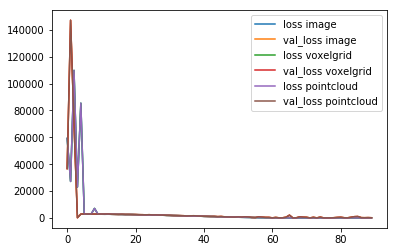

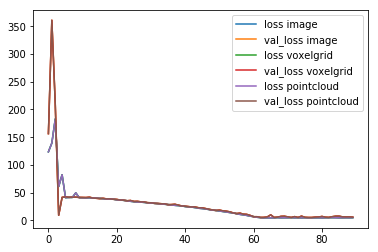

In [10]:
start_index = 10

# Loss.
for input_type, (_, history) in results.items():
    plt.plot(history["loss"][start_index:], label="loss" + " " + input_type)
    plt.plot(history["val_loss"][start_index:], label="val_loss" + " " + input_type)
plt.legend()
plt.show()
plt.close()

# Metric.
for input_type, (_, history) in results.items():
    plt.plot(history["mean_absolute_error"][start_index:], label="loss" + " " + input_type)
    plt.plot(history["val_mean_absolute_error"][start_index:], label="val_loss" + " " + input_type)
plt.legend()
plt.show()
plt.close()

# Test the model.

In [ ]:
# Evaluate.
for input_type, (model, _) in results.items():
    
    data_generator.input_type = input_type
    x_input, y_output = next(data_generator.generate(size=100, qrcodes_to_use=qrcodes_validate))
    loss, metric = model.evaluate(x_input, y_output, verbose=0)
    print("Input type:", input_type)
    print("Loss:", loss)
    print("Metric:", metric)
    print("")